In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Loading Data


In [55]:
# Load sample data due to comuting power limitations
data = pd.read_csv('sample_data.csv')

## EDA

In [3]:
# Number of rows and columns
print(f"Number of rows: {data.shape[0]}")
print(f"Number of columns: {data.shape[1]}")

Number of rows: 600000
Number of columns: 85


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Data columns (total 85 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Flow ID                      600000 non-null  object 
 1   Source IP                    600000 non-null  object 
 2   Source Port                  600000 non-null  float64
 3   Destination IP               600000 non-null  object 
 4   Destination Port             600000 non-null  float64
 5   Protocol                     600000 non-null  float64
 6   Timestamp                    600000 non-null  object 
 7   Flow Duration                600000 non-null  float64
 8   Total Fwd Packets            600000 non-null  float64
 9   Total Backward Packets       600000 non-null  float64
 10  Total Length of Fwd Packets  600000 non-null  float64
 11  Total Length of Bwd Packets  600000 non-null  float64
 12  Fwd Packet Length Max        600000 non-null  float64
 13 

### Missing Values

In [5]:
# Rows that contain olny NaN values
nan_rows = data[data.isnull().all(axis=1)]
print(f"Number of rows that contain only NaN values: {nan_rows.shape[0]}")

# Drop rows that contain only NaN values
data = data.dropna(how='all')
print(f"Number of rows after dropping rows that contain only NaN values: {data.shape[0]}")

Number of rows that contain only NaN values: 0
Number of rows after dropping rows that contain only NaN values: 600000


In [6]:
# Number of NaN values in each column
nan_values = data.isnull().sum()
print(f"Columns with NaN values:\n{nan_values[nan_values > 0]}")

Columns with NaN values:
Flow Bytes/s    305
dtype: int64


### Label 


The label column provides the classification for each network traffic record, indicating whether the traffic is benign or associated with a specific type of attack.

In [7]:
# BENIGN (noarmal traffic) VS everything else (attack traffic)
data['Label'].apply(lambda x: x=='BENIGN').value_counts(normalize=True)

Label
True     0.802822
False    0.197178
Name: proportion, dtype: float64

In [8]:
data['Label'].value_counts()

Label
BENIGN                        481693
DoS Hulk                       49307
PortScan                       33569
DDoS                           27025
DoS GoldenEye                   2200
FTP-Patator                     1667
SSH-Patator                     1262
DoS slowloris                   1250
DoS Slowhttptest                1141
Bot                              401
Web Attack – Brute Force         317
Web Attack – XSS                 152
Infiltration                       8
Web Attack – Sql Injection         6
Heartbleed                         2
Name: count, dtype: int64

### Distribution of Features

In [9]:
data["Flow ID"].nunique()


403458

<Axes: >

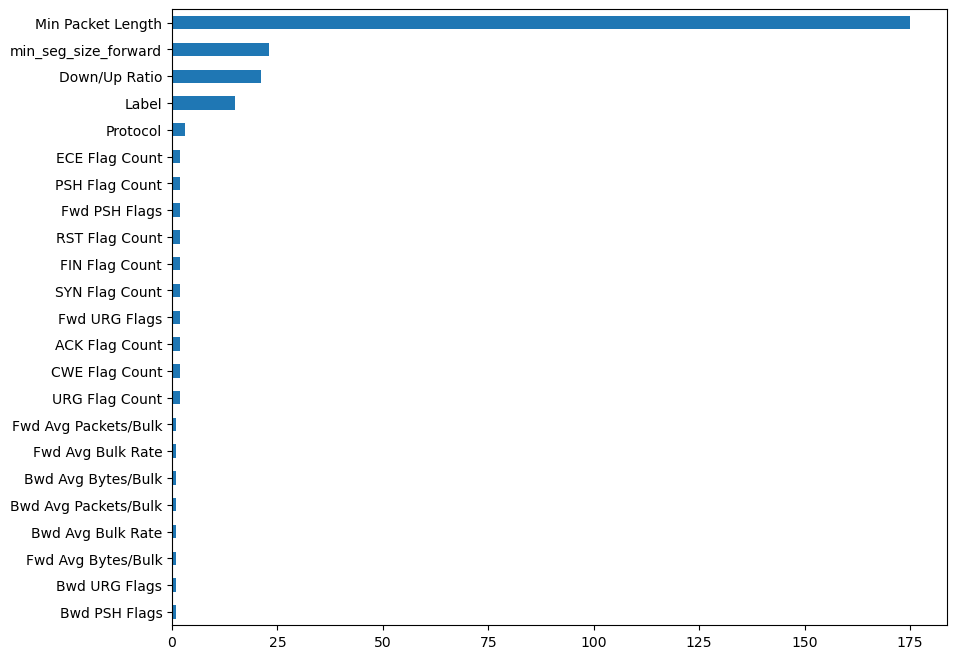

In [10]:
# Plot number of unique values in each column
unique_values = data.nunique()
unique_values[unique_values < 200].sort_values().plot(kind='barh', figsize=(10, 8))

In [11]:
data['Source Port'].value_counts()

Source Port
443.0      59915
80.0       26035
123.0       5065
137.0       1658
22.0        1027
           ...  
32310.0        1
14445.0        1
20791.0        1
22931.0        1
2165.0         1
Name: count, Length: 57492, dtype: int64

In [25]:
categorical_columns = data.select_dtypes(include=['object']).columns.to_list()
categorical_columns.extend([col for col in data.columns if data[col].nunique() <= 10])
categorical_columns.extend(["Source Port", "Destination Port"])
categorical_columns

['Flow ID',
 'Source IP',
 'Destination IP',
 'Timestamp',
 'Label',
 'Protocol',
 'Fwd PSH Flags',
 'Bwd PSH Flags',
 'Fwd URG Flags',
 'Bwd URG Flags',
 'FIN Flag Count',
 'SYN Flag Count',
 'RST Flag Count',
 'PSH Flag Count',
 'ACK Flag Count',
 'URG Flag Count',
 'CWE Flag Count',
 'ECE Flag Count',
 'Fwd Avg Bytes/Bulk',
 'Fwd Avg Packets/Bulk',
 'Fwd Avg Bulk Rate',
 'Bwd Avg Bytes/Bulk',
 'Bwd Avg Packets/Bulk',
 'Bwd Avg Bulk Rate',
 'Source Port',
 'Destination Port']

In [26]:
numerical_columns = data.columns.difference(categorical_columns).to_list()
numerical_columns

['Active Max',
 'Active Mean',
 'Active Min',
 'Active Std',
 'Average Packet Size',
 'Avg Bwd Segment Size',
 'Avg Fwd Segment Size',
 'Bwd Header Length',
 'Bwd IAT Max',
 'Bwd IAT Mean',
 'Bwd IAT Min',
 'Bwd IAT Std',
 'Bwd IAT Total',
 'Bwd Packet Length Max',
 'Bwd Packet Length Mean',
 'Bwd Packet Length Min',
 'Bwd Packet Length Std',
 'Bwd Packets/s',
 'Down/Up Ratio',
 'Flow Bytes/s',
 'Flow Duration',
 'Flow IAT Max',
 'Flow IAT Mean',
 'Flow IAT Min',
 'Flow IAT Std',
 'Flow Packets/s',
 'Fwd Header Length',
 'Fwd Header Length.1',
 'Fwd IAT Max',
 'Fwd IAT Mean',
 'Fwd IAT Min',
 'Fwd IAT Std',
 'Fwd IAT Total',
 'Fwd Packet Length Max',
 'Fwd Packet Length Mean',
 'Fwd Packet Length Min',
 'Fwd Packet Length Std',
 'Fwd Packets/s',
 'Idle Max',
 'Idle Mean',
 'Idle Min',
 'Idle Std',
 'Init_Win_bytes_backward',
 'Init_Win_bytes_forward',
 'Max Packet Length',
 'Min Packet Length',
 'Packet Length Mean',
 'Packet Length Std',
 'Packet Length Variance',
 'Subflow Bwd Bytes'

In [27]:
assert len(categorical_columns) + len(numerical_columns) == data.shape[1]

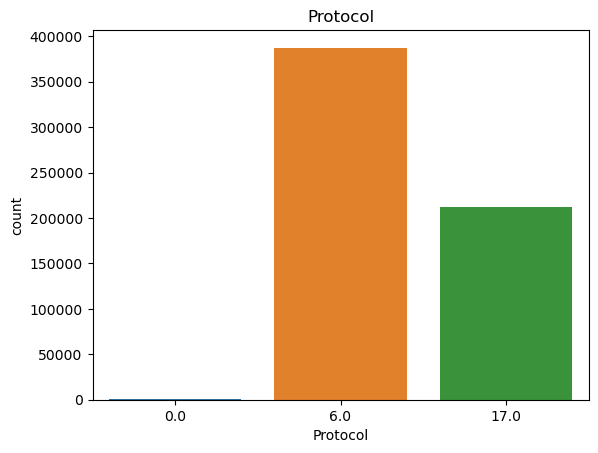

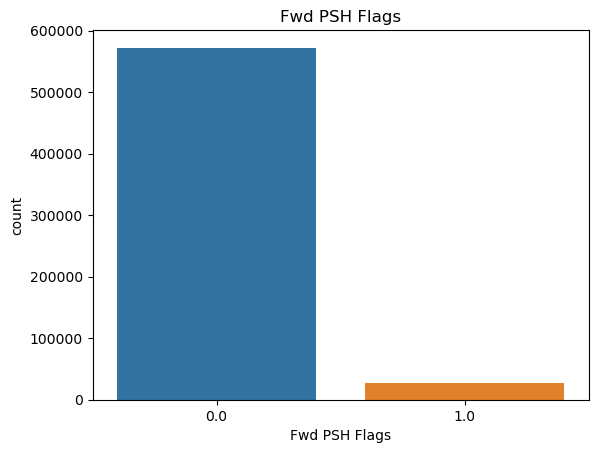

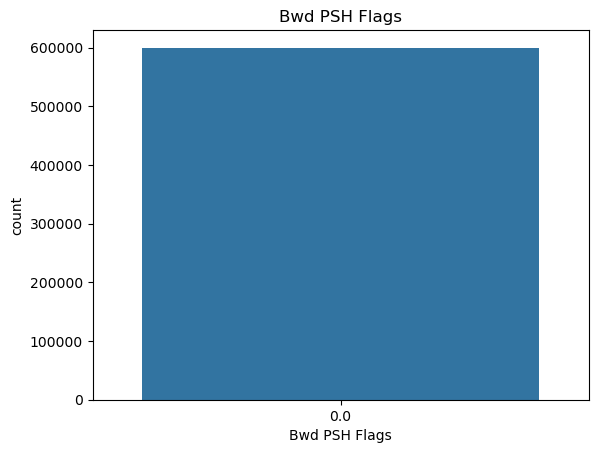

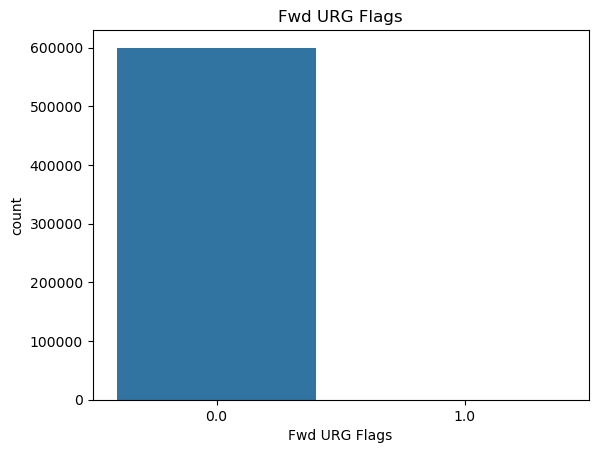

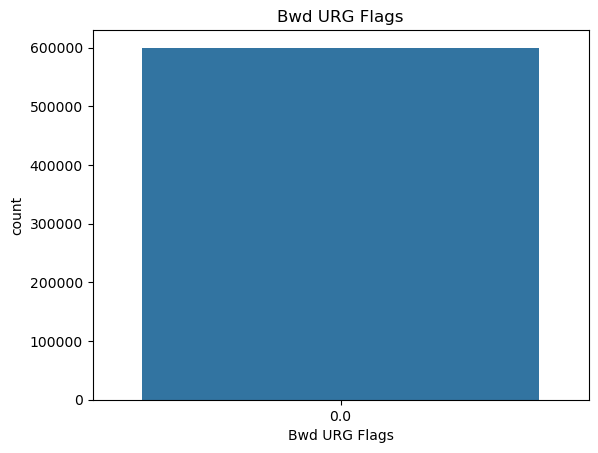

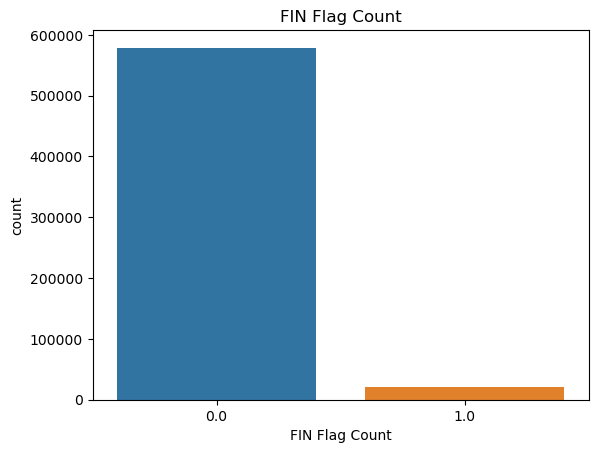

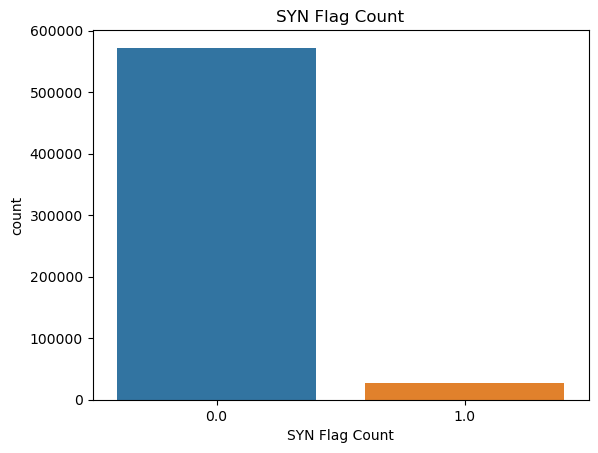

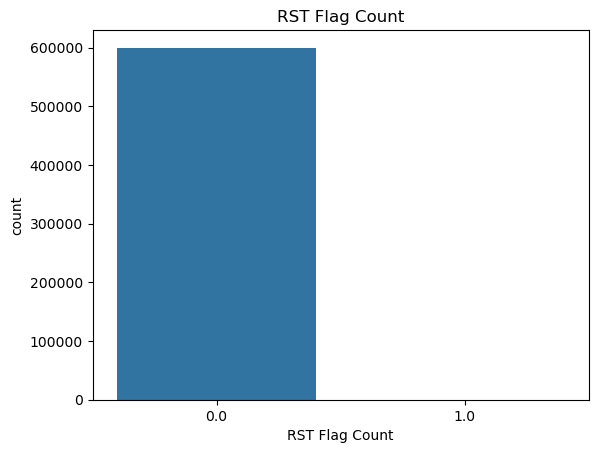

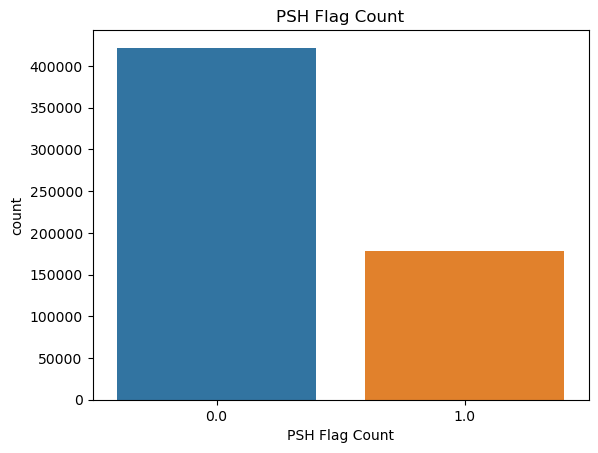

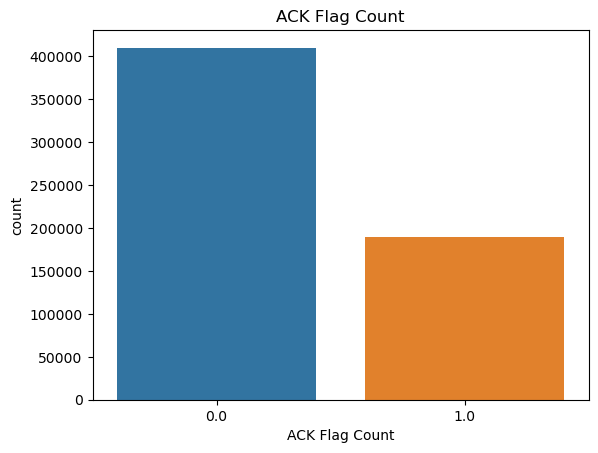

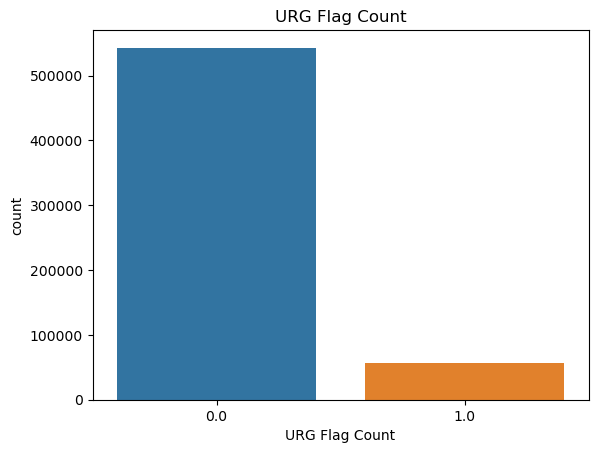

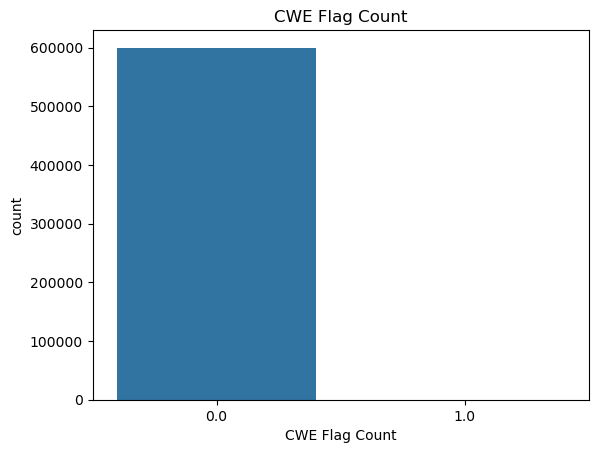

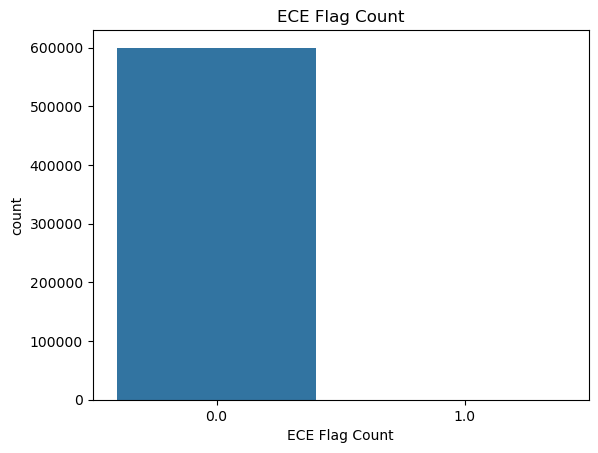

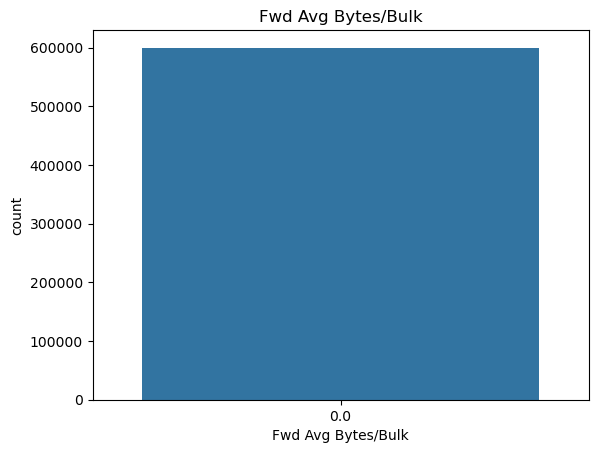

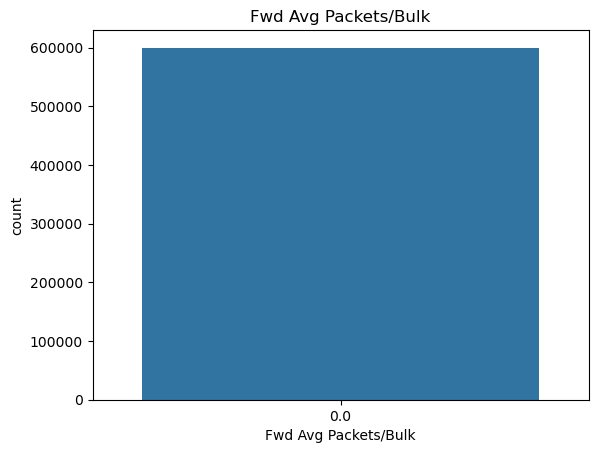

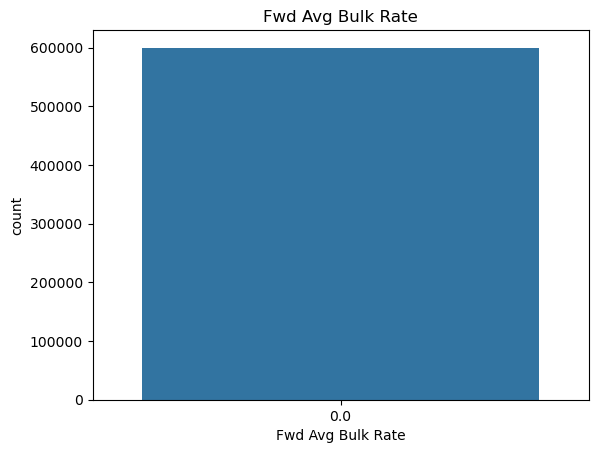

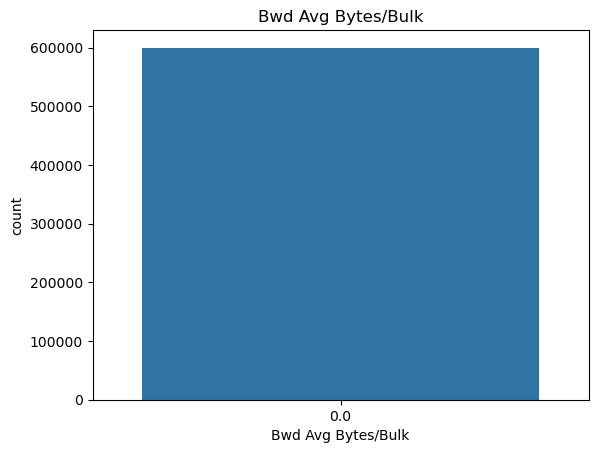

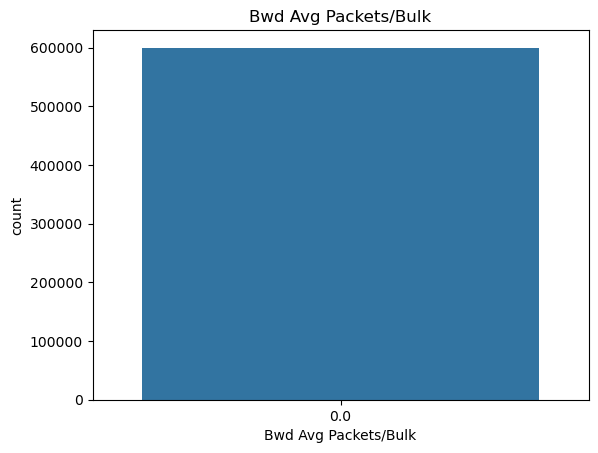

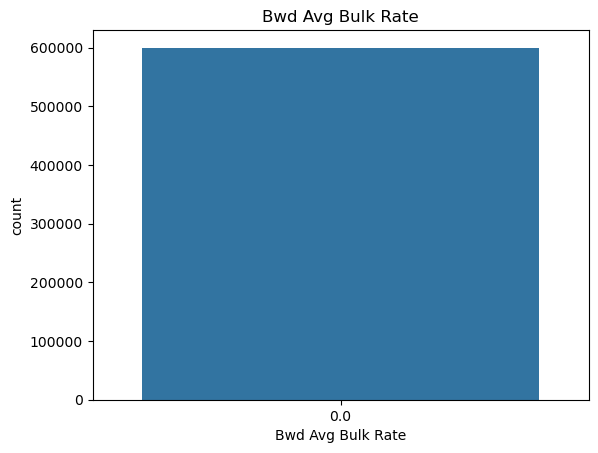

In [28]:
for col in categorical_columns:
    if data[col].nunique() <= 10:
        sns.countplot(x=col, data=data)
        plt.title(col)
        plt.show()

    

I observe four types of categorical features:

1. **Network IDs** (not plotted): including Port, IP, and Flow ID. These should be nearly identical, but when they aren't, meaningful features can be derived. Refer to the preprocessing section.
2. **Protocol**: Contains exactly three options, none of which are extremely rare.
3. **Binary Features**: All have a significantly predominant value.
4. **Feature with Only One Unique Value**

In [29]:
# To plot distribution of numerical columns we need to remove NaN and Inf values

# Replace NaN values with mean value of the column "Flow Bytes/s"
data['Flow Bytes/s'].fillna(data['Flow Bytes/s'].mean(), inplace=True)


In [30]:
# Replace Inf values with max value of each column
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.fillna(data.max(), inplace=True)

In [31]:
print(f"Number of inf in data: {data.isin([np.inf, -np.inf]).sum().sum()}")

Number of inf in data: 0


In [62]:

def plot_distribution(data, columns, num_cols=4):
    num_rows = len(columns) // num_cols + 1
    plt.figure(figsize=(20, 5 * num_rows))

    for i, col in enumerate(columns):
        plt.subplot(num_rows, num_cols, i + 1)
        
        # Use different colors based on the label
        if 'Label' in data.columns:
            for label in data['Label'].unique():
                color = 'blue' if label == 'BENIGN' else 'red'  # Adjust colors as needed
                sns.histplot(data[data['Label'] == label][col], bins=50, color=color, label=label, kde=True)
            
            plt.legend(title='Label')
        else:
            sns.histplot(data[col], bins=50, kde=True)

        plt.title(col)

    plt.tight_layout()
    plt.show()


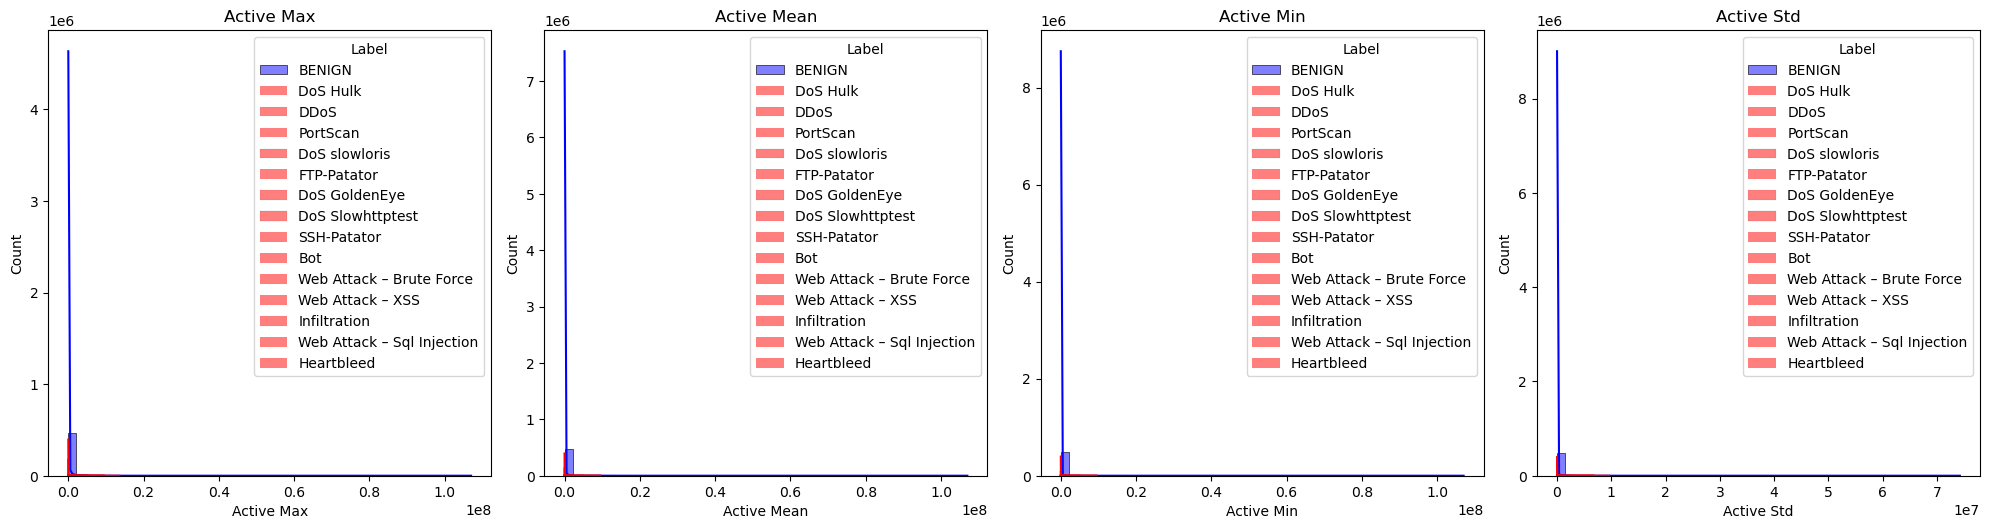

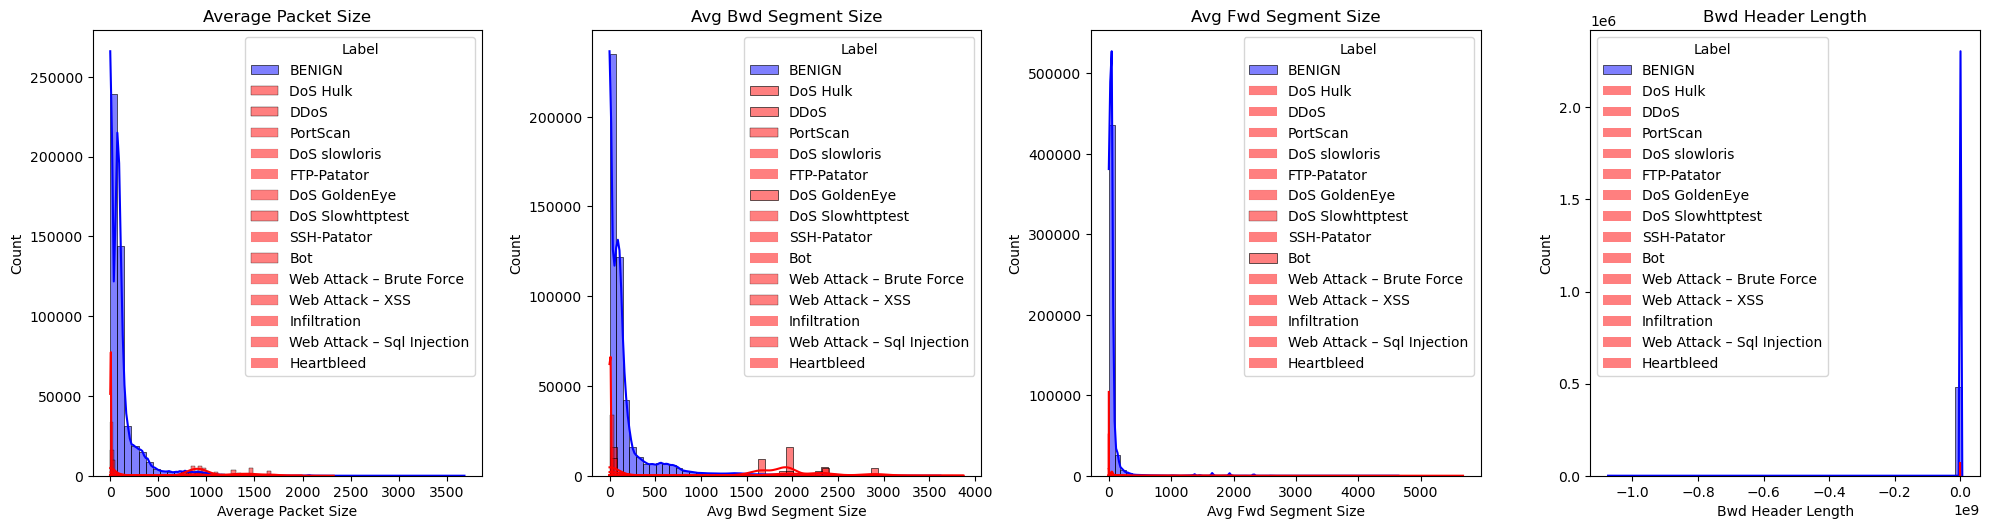

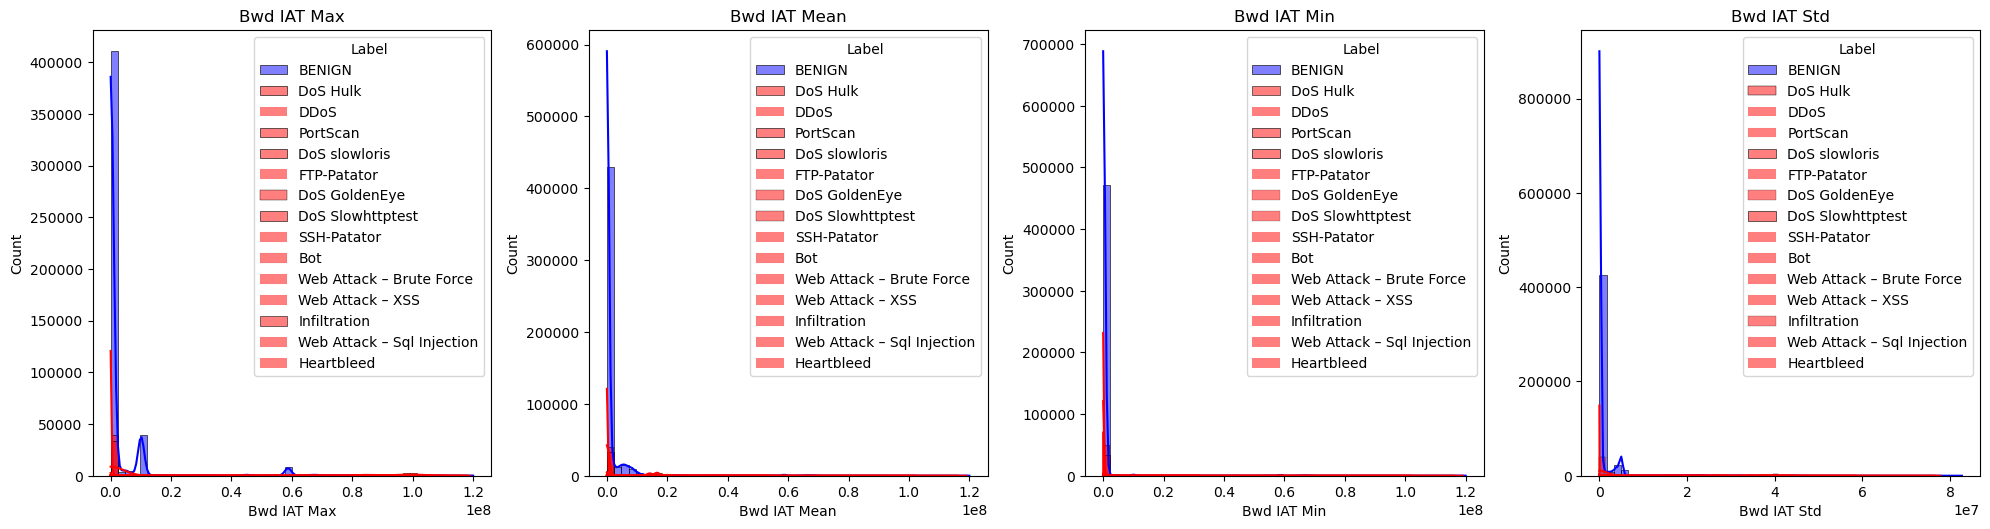

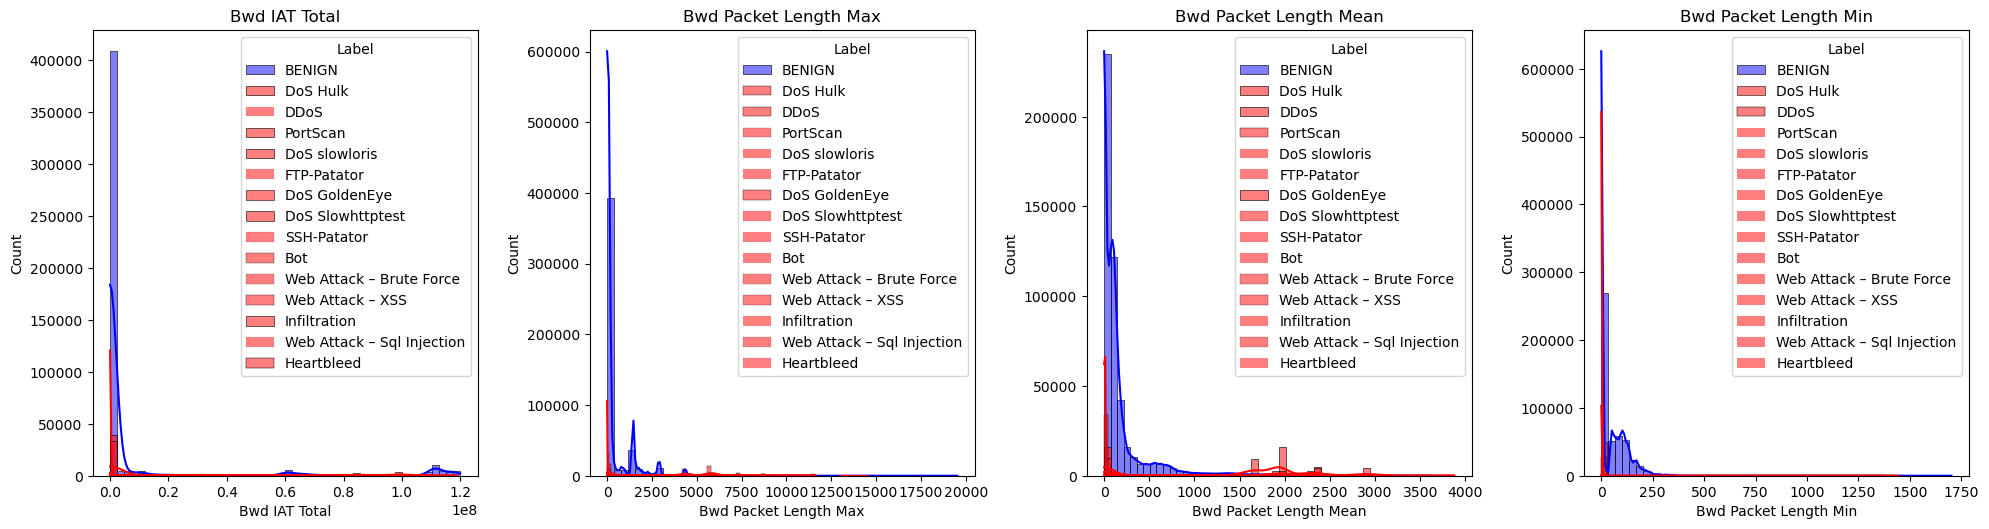

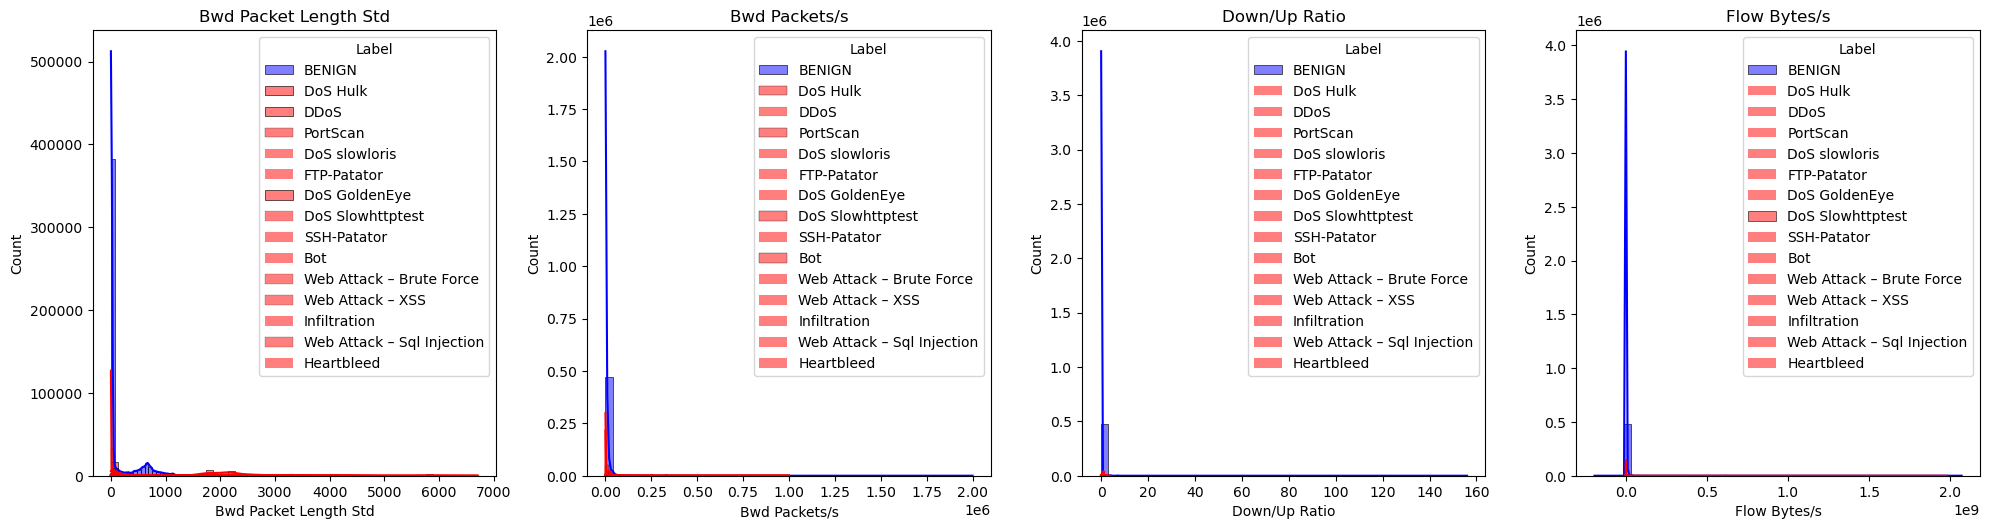

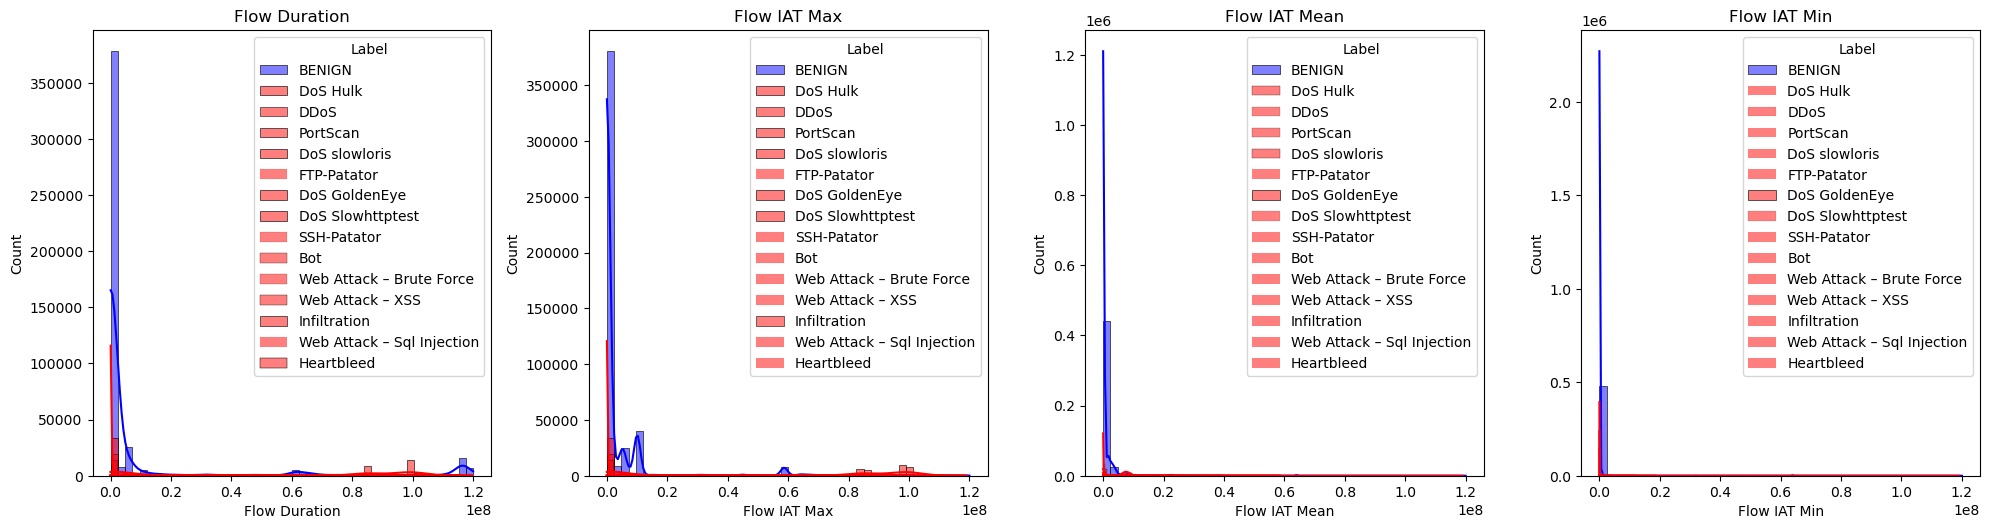

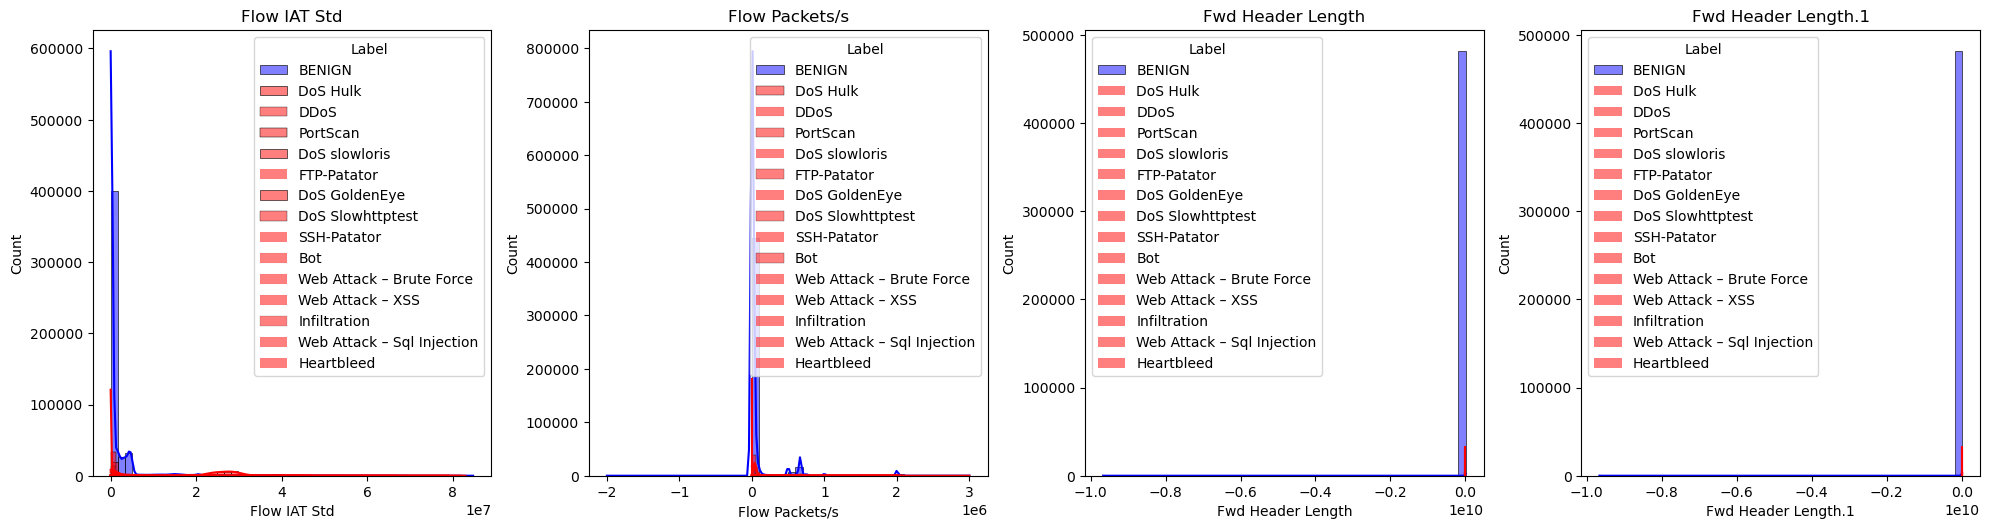

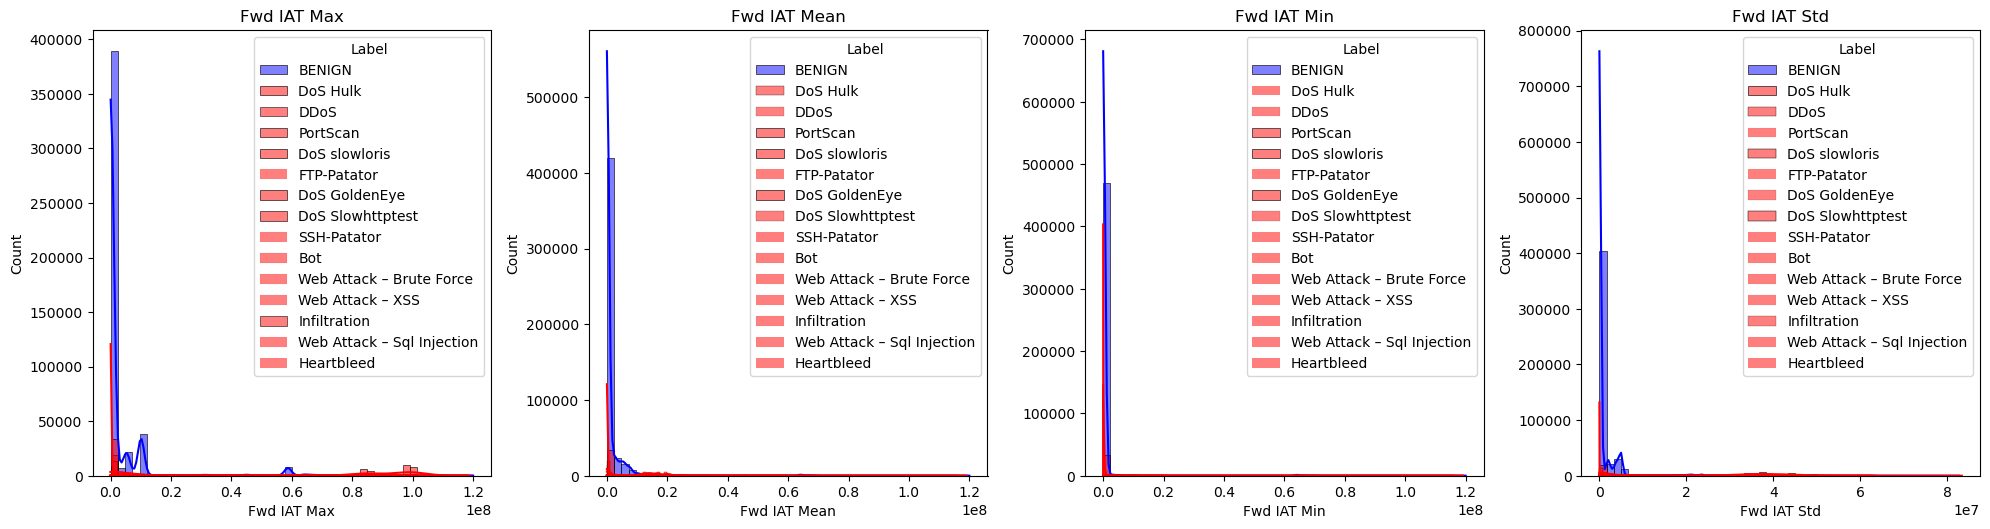

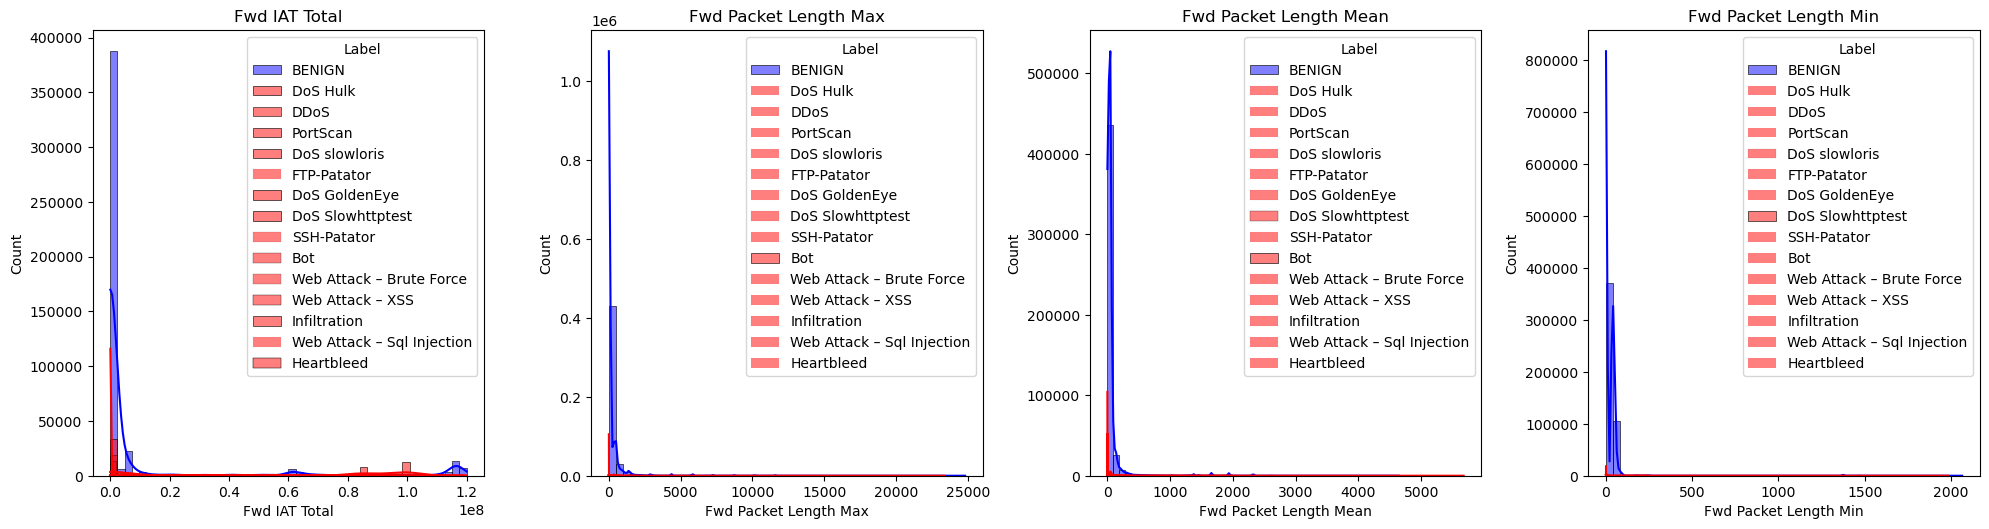

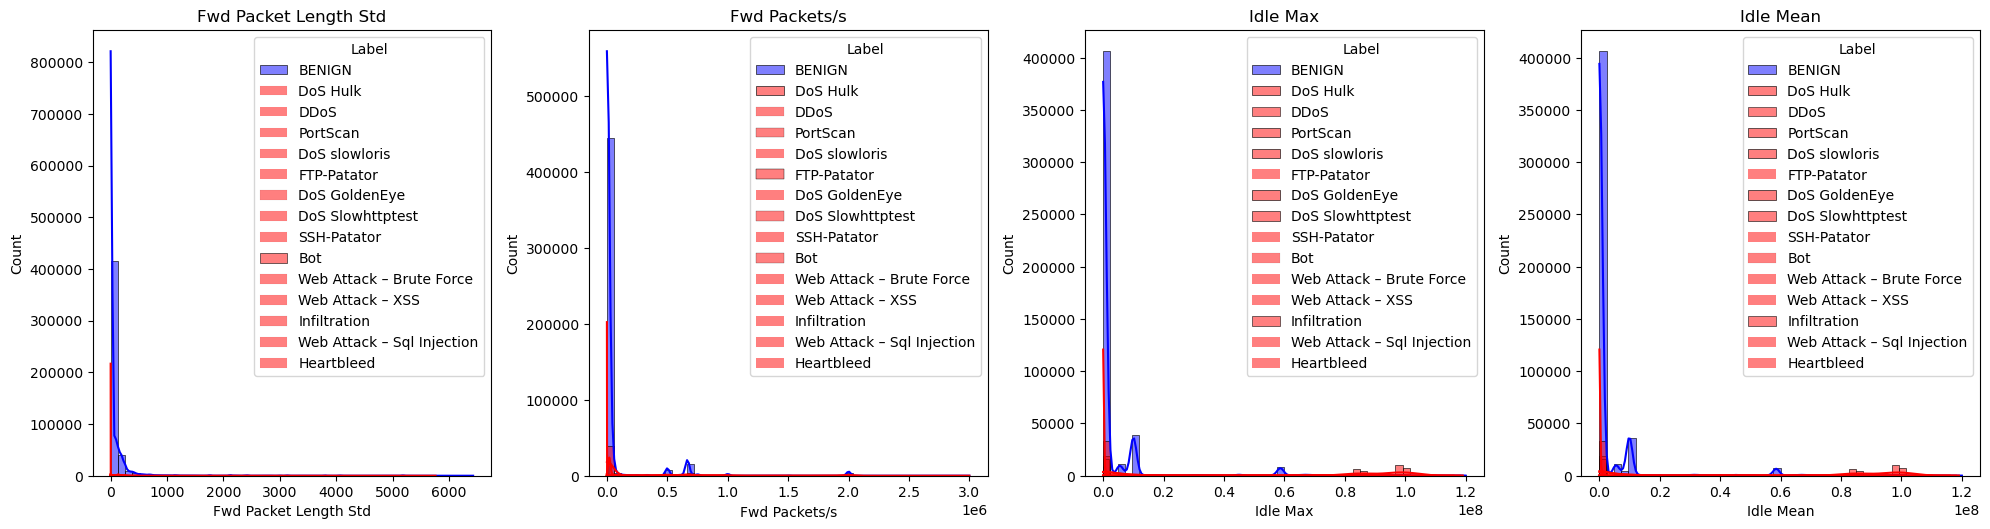

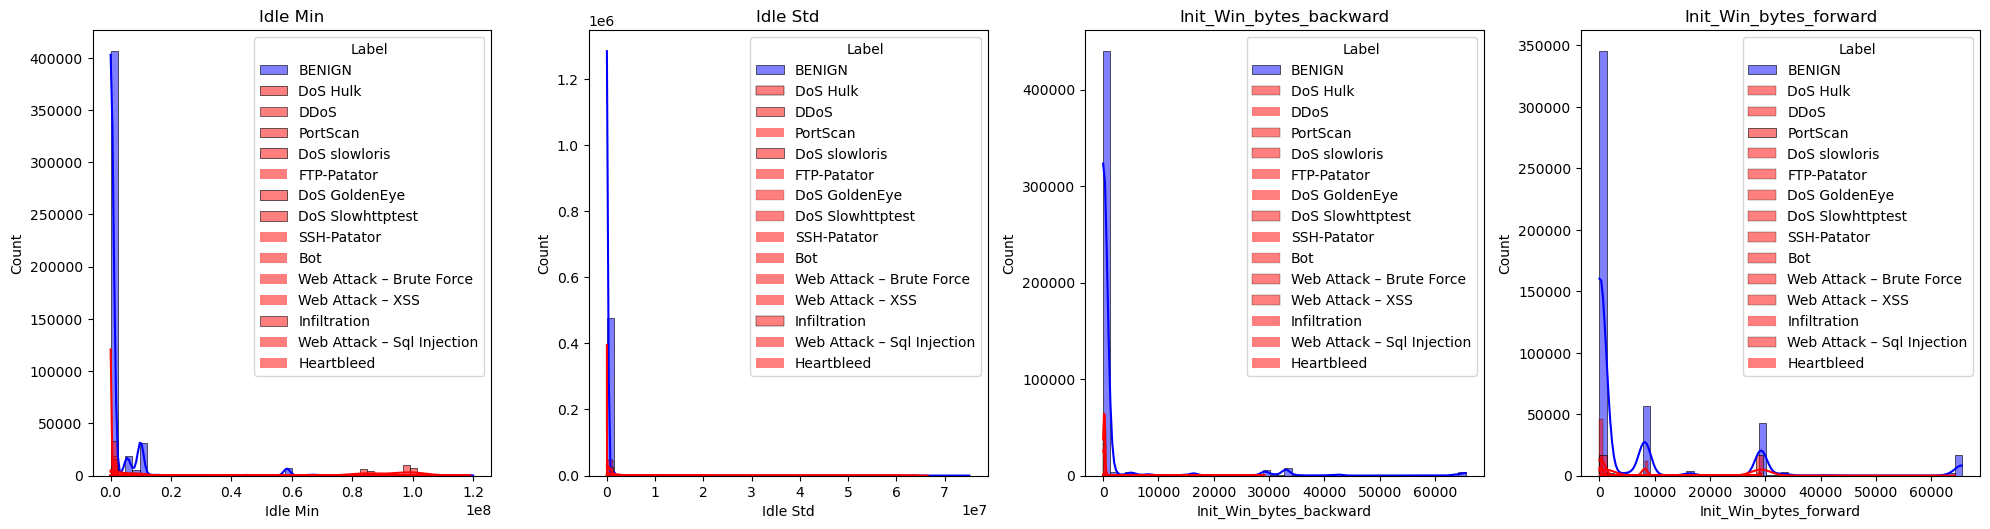

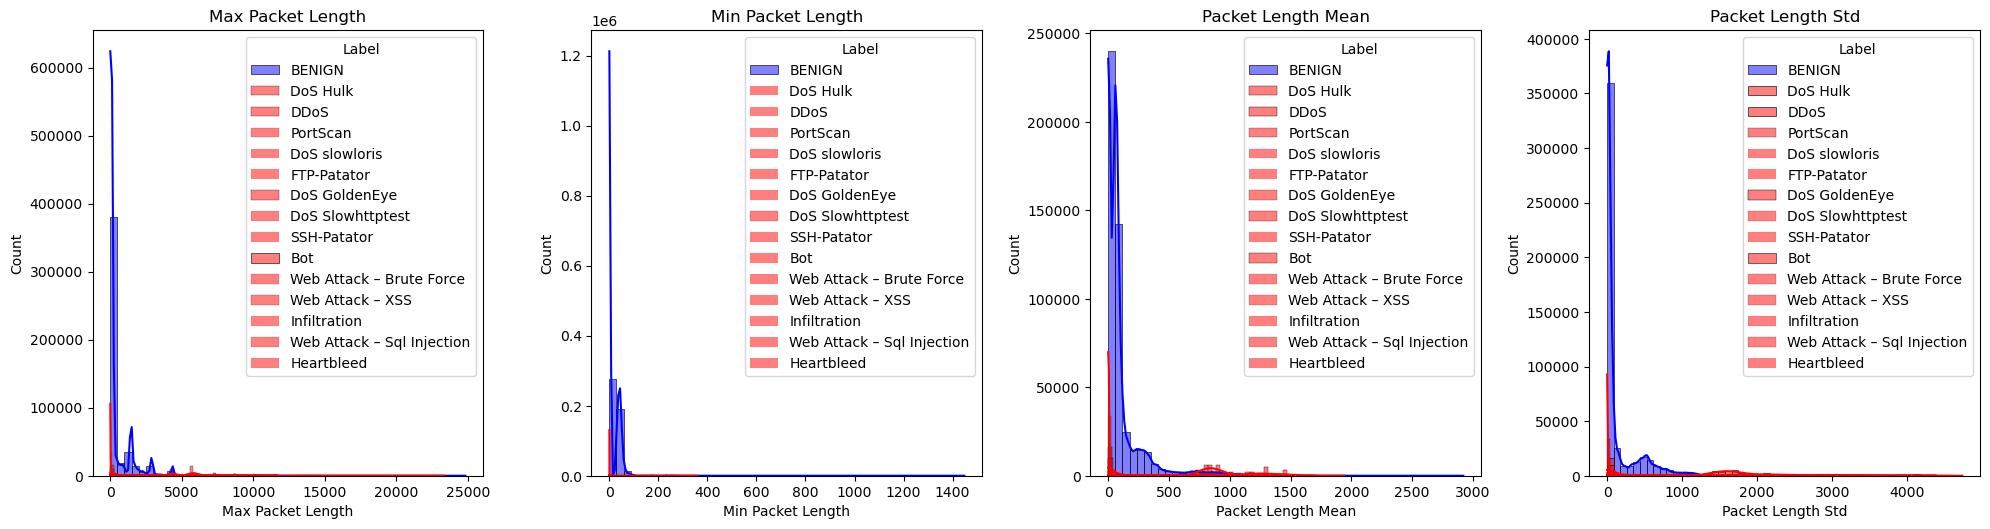

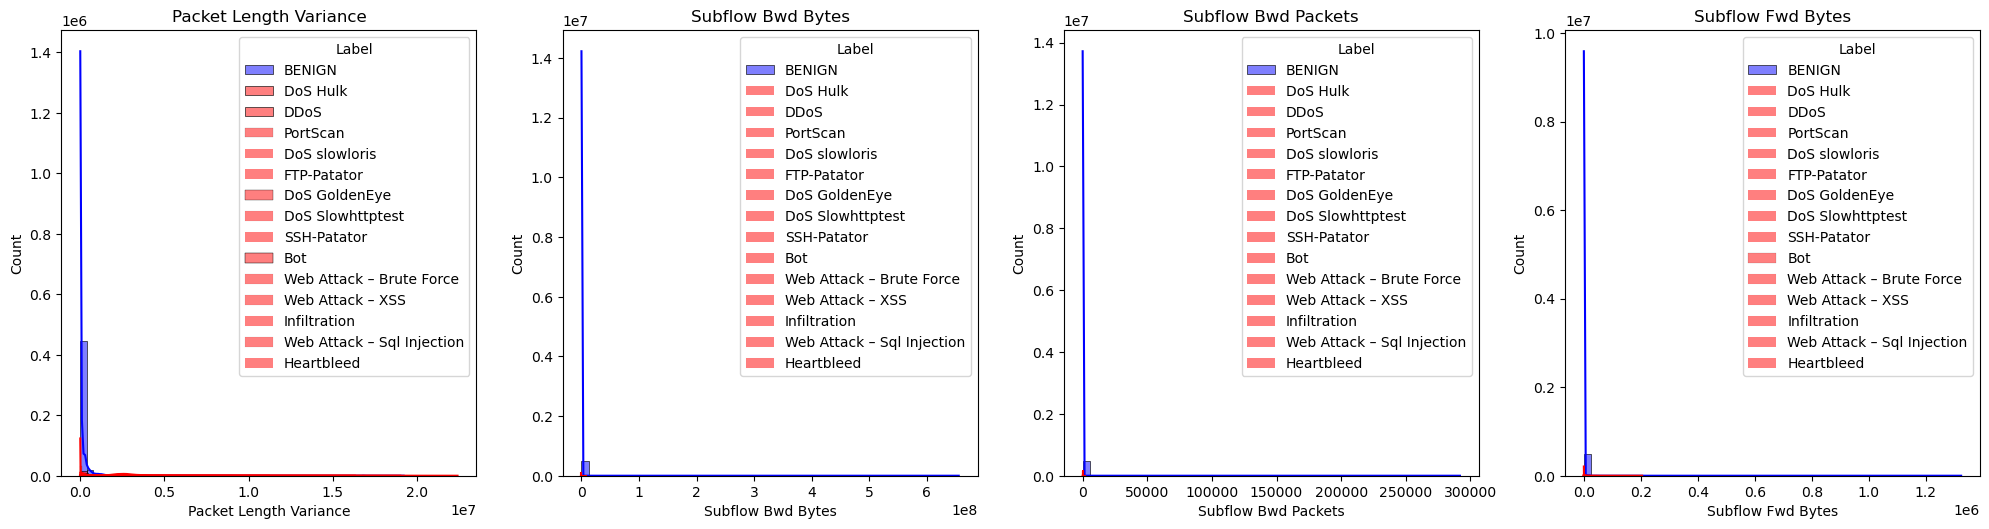

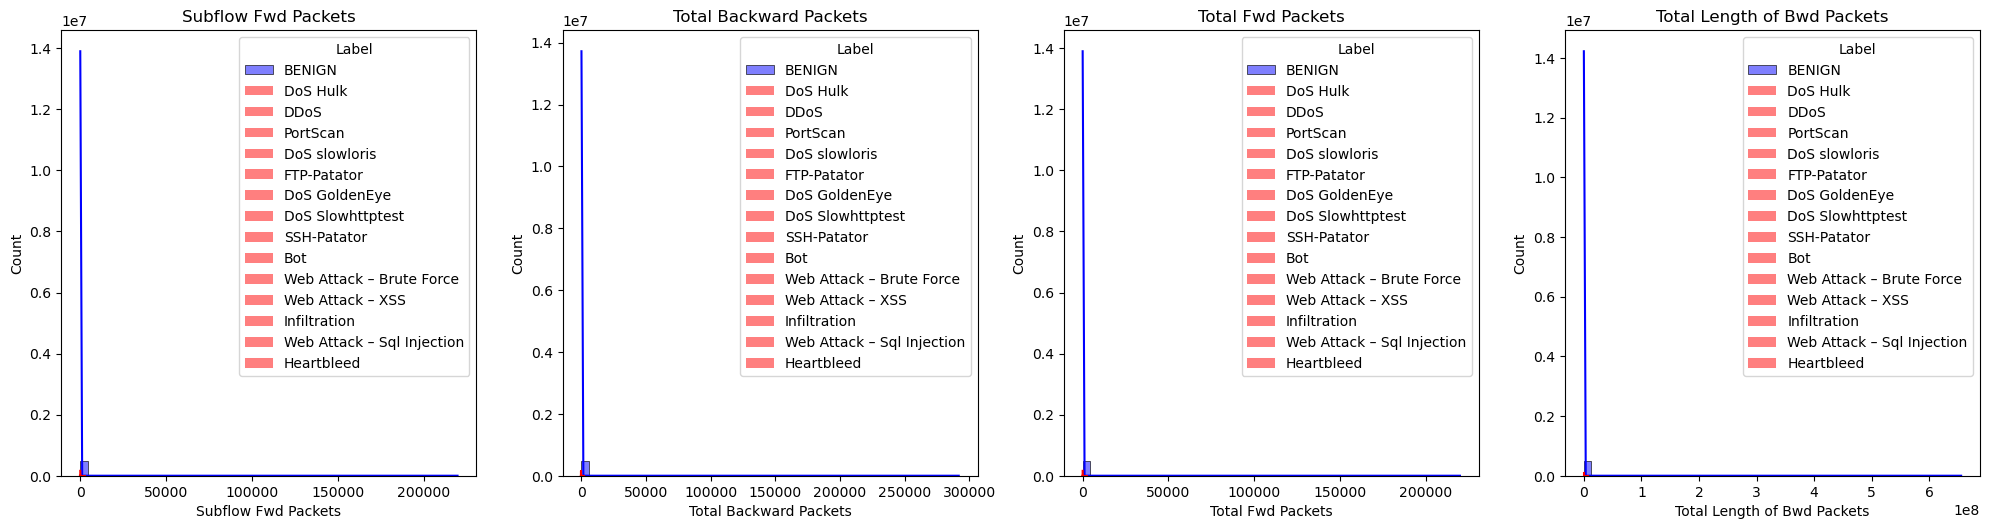

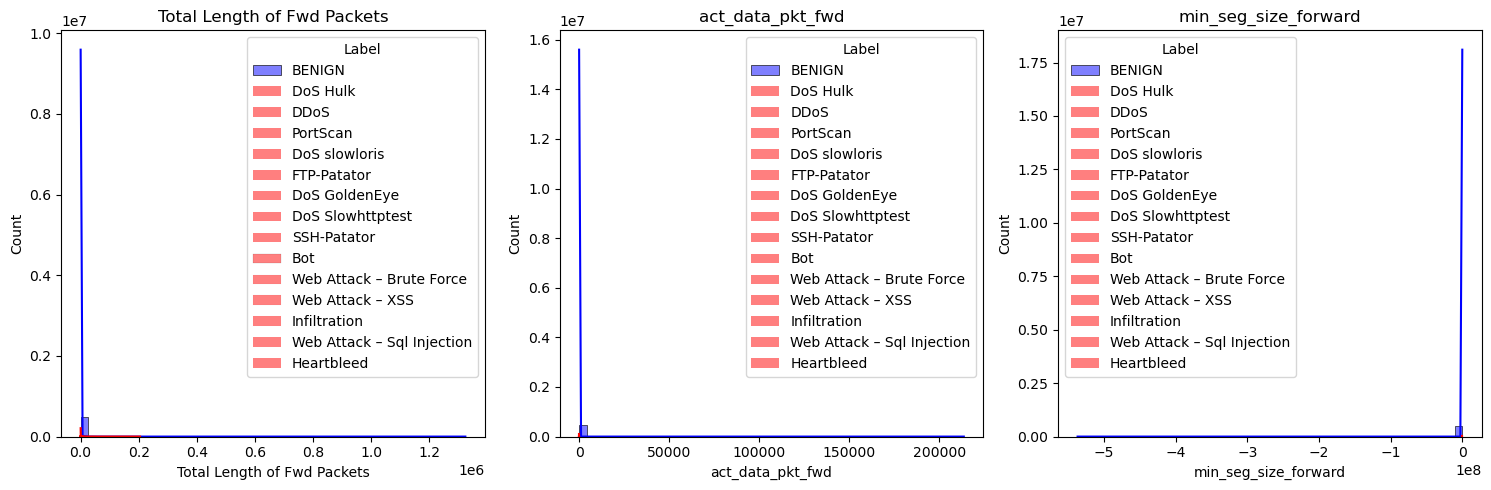

In [63]:
nuber_of_columns_to_plot = 4
for i in range(0, len(numerical_columns), nuber_of_columns_to_plot):
    with pd.option_context('mode.use_inf_as_na', True):
        plot_distribution(data, numerical_columns[i:i+nuber_of_columns_to_plot])

Here are some observations about the distribution of numerical features:

* Some features that are expected to be only positive include negative values.
* Many features exhibit a long tail with very high values that are significantly different from the rest. I plan to retain these outliers, as they may indicate potential attacks.
* It will be interesting to analyze how the hue color represents attack versus benign instances in each distribution.

### Correlation with target



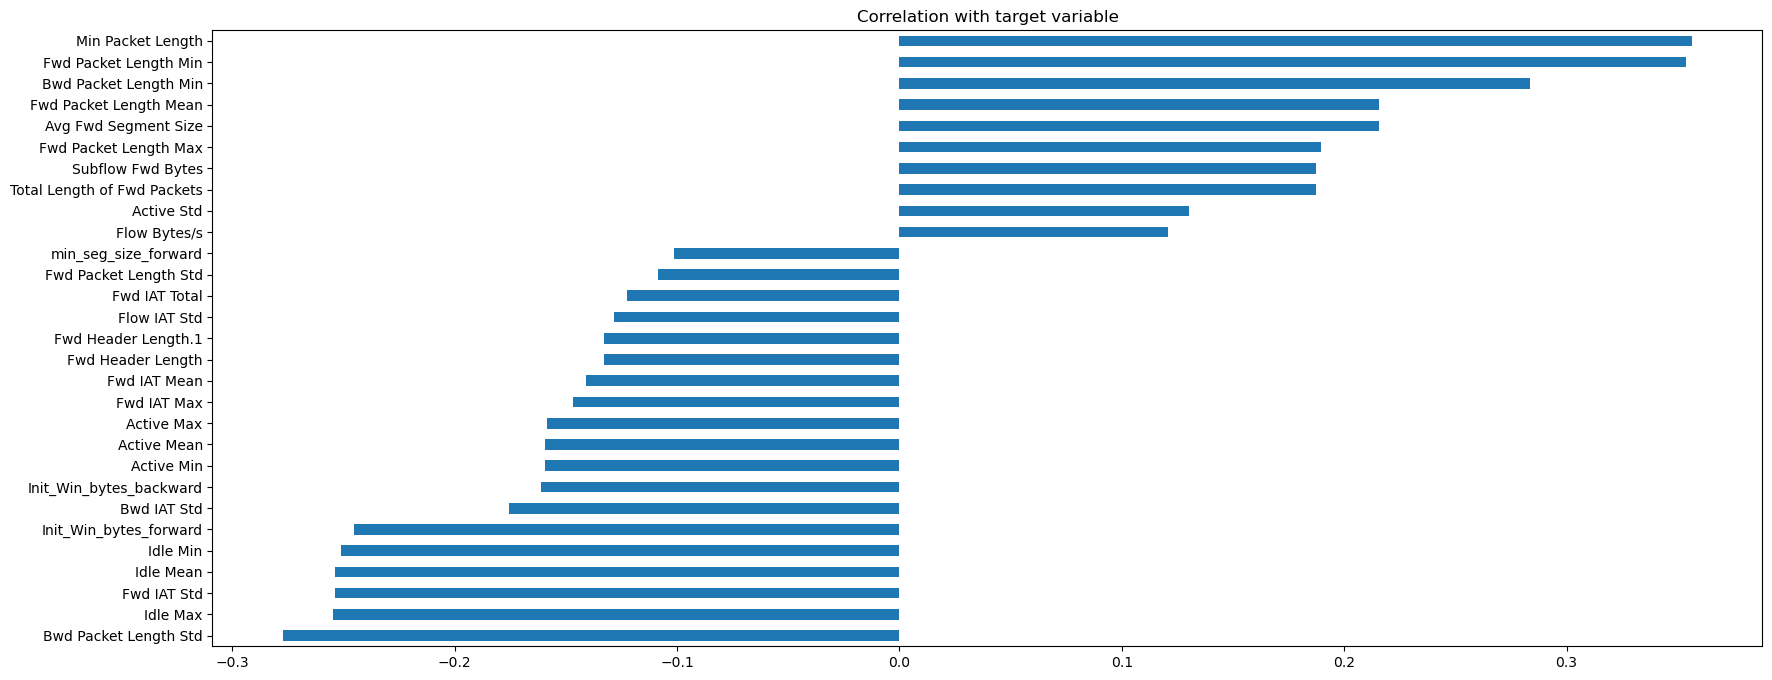

In [35]:
# First see if any of the numeric featues are corrlated with Attack vs Benign
# Spearman correlation is used because it is more robust to outliers
carrelation_attack = data[numerical_columns].apply(lambda x: x.corr(data['Label'].apply(lambda x: x=='BENIGN'), method='spearman'))
# Filter correlation values above 0.1
carrelation_attack = carrelation_attack[carrelation_attack.abs() > 0.1]

# Plot correlation with target variable
plt.figure(figsize=(20, 8))
carrelation_attack.sort_values().plot(kind='barh')
plt.title('Correlation with target variable')
plt.show()

Some insight from the corrlation
Explain what is correlation and the meaning

**Correlation** is how

## Preprocessing


In [36]:
data.head()


,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,192.168.10.1-192.168.10.3-53-60765-17,192.168.10.3,60765.0,192.168.10.1,53.0,17.0,7/7/2017 9:19,334020.0,1.0,1.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
1,192.168.10.3-192.168.10.15-53-49334-17,192.168.10.15,49334.0,192.168.10.3,53.0,17.0,6/7/2017 9:24,165.0,2.0,2.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
2,172.16.0.1-192.168.10.50-53066-80-6,172.16.0.1,53066.0,192.168.10.50,80.0,6.0,5/7/2017 10:43,99951883.0,9.0,7.0,...,32.0,999.0,0.0,999.0,999.0,99900000.0,0.0,99900000.0,99900000.0,DoS Hulk
3,192.168.10.1-192.168.10.3-53-61051-17,192.168.10.3,61051.0,192.168.10.1,53.0,17.0,6/7/2017 4:27,78980.0,1.0,1.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
4,172.16.0.1-192.168.10.50-59155-80-6,172.16.0.1,59155.0,192.168.10.50,80.0,6.0,7/7/2017 4:02,4225343.0,5.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DDoS


In [37]:
# Starting with essential preprocessing

# Dropping columns with only one unique value
columns_to_drop = [col for col in data.columns if data[col].nunique() == 1]
data.drop(columns=columns_to_drop, inplace=True)


### Encoding Labels

In [38]:
label_encoder = LabelEncoder()
label_encoder.fit(data['Label'])
data['Label'] = label_encoder.transform(data['Label'])

print(label_encoder.classes_)
data['Label'].value_counts()

['BENIGN' 'Bot' 'DDoS' 'DoS GoldenEye' 'DoS Hulk' 'DoS Slowhttptest'
 'DoS slowloris' 'FTP-Patator' 'Heartbleed' 'Infiltration' 'PortScan'
 'SSH-Patator' 'Web Attack – Brute Force' 'Web Attack – Sql Injection'
 'Web Attack – XSS']


Label
0     481693
4      49307
10     33569
2      27025
3       2200
7       1667
11      1262
6       1250
5       1141
1        401
12       317
14       152
9          8
13         6
8          2
Name: count, dtype: int64

In [64]:
# Save label encoder to use it with other files too
import joblib
joblib.dump(label_encoder, 'label_encoder.pkl')


['label_encoder.pkl']

### Split data

In [39]:
X = data.drop(columns=['Label'])
y = data['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### Enconding Categorical Featueres

In [40]:
# Protocol column
data['Protocol'].value_counts()

Protocol
6.0     387385
17.0    212255
0.0        360
Name: count, dtype: int64

The "Protocol" column is not numeric, meaning the order of its values doesn't matter. For example, protocol 17 is not greater than protocol 6; they are simply different. To prevent misleading an ML model about the nature of this column, I will use one-hot encoding.

In [41]:
# One hot encoding for the Protocol column
X_train = pd.get_dummies(X_train, columns=['Protocol'])
X_test = pd.get_dummies(X_test, columns=['Protocol'])

X_train.head()

,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Protocol_0.0,Protocol_6.0,Protocol_17.0
425219,172.16.0.1-192.168.10.50-58618-80-6,172.16.0.1,58618.0,192.168.10.50,80.0,5/7/2017 10:56,84423092.0,7.0,6.0,327.0,...,0.000,995.0,995.0,8.430000e+07,0.000000e+00,84300000.0,84300000.0,False,True,False
102722,192.168.10.8-192.168.10.14-45328-135-6,192.168.10.8,45328.0,192.168.10.14,135.0,6/7/2017 3:28,20999785.0,4.0,10.0,0.0,...,2121278.624,2999944.0,3.0,8.999896e+06,4.242114e+06,12000000.0,6000268.0,False,True,False
172474,192.168.10.8-23.198.111.103-2732-443-6,192.168.10.8,2732.0,23.198.111.103,443.0,6/7/2017 3:37,112598507.0,25.0,28.0,4761.0,...,1041216.514,3587527.0,77140.0,9.758139e+06,4.602564e+05,9994201.0,8395407.0,False,True,False
238537,192.168.10.3-192.168.10.16-53-20799-17,192.168.10.16,20799.0,192.168.10.3,53.0,6/7/2017 1:42,31038.0,2.0,2.0,72.0,...,0.000,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,False,False,True
129503,192.168.10.3-192.168.10.14-53-57858-17,192.168.10.14,57858.0,192.168.10.3,53.0,5/7/2017 2:59,160.0,2.0,2.0,82.0,...,0.000,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,False,False,True


### Dropping Columns Not Used for Training

If time allows, I will extract meaningful features from these columns:

1. **Timestamp**: Convert to three columns: Day of the week, hour, and minute.
2. **Port (Source and Destination)**: Although numeric, similar to 'Protocol', it is categorical and unordered. With numerous possible values, one-hot encoding would create too many columns. My solution is to group ports into 3 or 4 categories, ranging from frequently used to rarely used ports, and then apply one-hot encoding.
3. **IP (Source and Destination)**: Split the IP into its parts and record the frequency of each part in the previous timestamp (e.g., the last 15 minutes). I am considering whether to count across all timestamps or only previously seen values to prevent data leakage.
4. **Flow ID**: Similar to IP, count the frequency of occurrence in timestamp.


In [42]:
columns_to_drop = ['Flow ID', 'Source IP', 'Source Port', 'Destination IP', 'Destination Port', 'Timestamp']
X_train.drop(columns=columns_to_drop, inplace=True)
X_test.drop(columns=columns_to_drop, inplace=True)

In [43]:
# Remaining columns:
columns = X_train.columns
print(f"Columns for training: {len(columns)}")
columns

Index(['Flow Duration', 'Total Fwd Packets', 'Total Backward Packets',
       'Total Length of Fwd Packets', 'Total Length of Bwd Packets',
       'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Fwd Packet Length Mean', 'Fwd Packet Length Std',
       'Bwd Packet Length Max', 'Bwd Packet Length Min',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags',
       'Fwd URG Flags', 'Fwd Header Length', 'Bwd Header Length',
       'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length',
       'Max Packet Length', 'Packet Length Mean', 'Packet Length Std',
       'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count',
       'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', '

### Scaling


In [44]:
# scaling the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [45]:
# Save train and test data
np.save("X_train_sample.npy", X_train)
np.save("X_test_sample.npy", X_test)
np.save("y_train_sample.npy", y_train)
np.save("y_test_sample.npy", y_test)

## Train Classical ML model(s)

In [46]:
### Random Forest Classifier

rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

print(f"Train accuracy: {rf.score(X_train, y_train)}")
print(f"Test accuracy: {rf.score(X_test, y_test)}")


Train accuracy: 0.9993770833333333
Test accuracy: 0.9979833333333333


<Axes: >

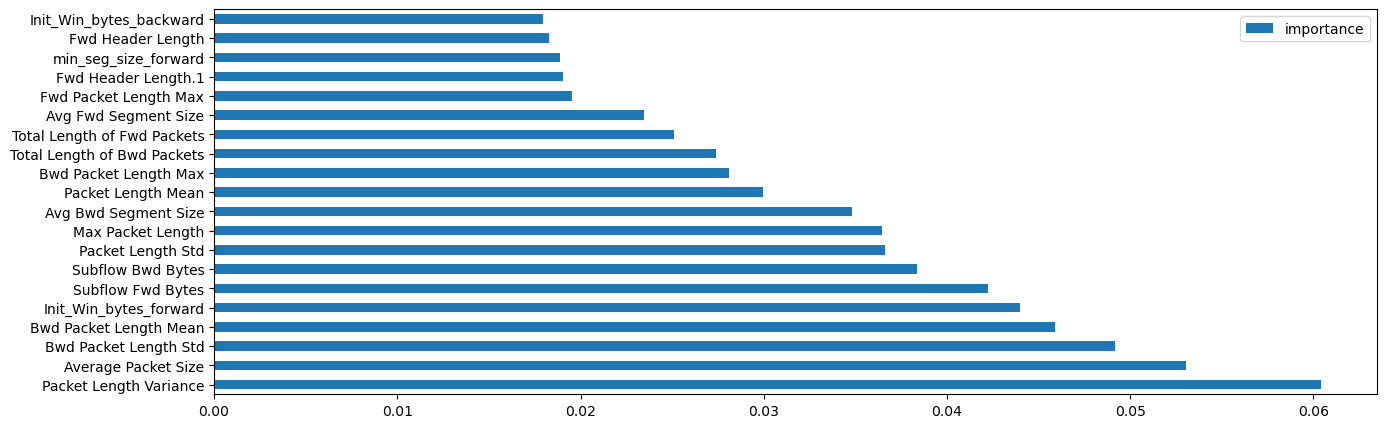

In [47]:
feature_importances = pd.DataFrame(rf.feature_importances_, index=columns, columns=['importance']).sort_values('importance', ascending=False)
feature_importances.head(20).plot(kind='barh', figsize=(15, 5))

In [53]:
# Test the model on the test data
from sklearn.metrics import confusion_matrix, classification_report

y_pred = rf.predict(X_test)
y_test_labels = label_encoder.inverse_transform(y_test)
y_pred_labels = label_encoder.inverse_transform(y_pred)

# Confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=label_encoder.classes_)
cm = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)
cm

,BENIGN,Bot,DDoS,DoS GoldenEye,DoS Hulk,DoS Slowhttptest,DoS slowloris,FTP-Patator,Heartbleed,Infiltration,PortScan,SSH-Patator,Web Attack – Brute Force,Web Attack – Sql Injection,Web Attack – XSS
BENIGN,96325,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Bot,0,58,0,0,0,0,0,0,0,0,0,0,0,0,0
DDoS,0,0,5402,0,0,0,0,0,0,0,0,0,0,0,0
DoS GoldenEye,0,0,0,432,0,0,0,0,0,0,0,0,0,0,0
DoS Hulk,0,0,0,0,9872,0,0,0,0,0,0,0,0,0,0
DoS Slowhttptest,0,0,0,0,0,239,0,0,0,0,0,0,0,0,0
DoS slowloris,0,0,0,0,0,0,250,0,0,0,0,0,0,0,0
FTP-Patator,0,0,0,0,0,0,0,334,0,0,0,0,0,0,0
Heartbleed,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Infiltration,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0


In [54]:
# Classification report
print(classification_report(y_test_labels, y_pred_labels))

                          precision    recall  f1-score   support

                  BENIGN       1.00      1.00      1.00     96325
                     Bot       1.00      1.00      1.00        58
                    DDoS       1.00      1.00      1.00      5402
           DoS GoldenEye       1.00      1.00      1.00       432
                DoS Hulk       1.00      1.00      1.00      9872
        DoS Slowhttptest       1.00      1.00      1.00       239
           DoS slowloris       1.00      1.00      1.00       250
             FTP-Patator       1.00      1.00      1.00       334
            Infiltration       1.00      1.00      1.00         2
                PortScan       1.00      1.00      1.00      6752
             SSH-Patator       1.00      1.00      1.00       242
Web Attack – Brute Force       1.00      1.00      1.00        69
        Web Attack – XSS       1.00      1.00      1.00        23

                accuracy                           1.00    120000
        